In [24]:
from cell_env import CellEnv
# Use sb3 env checker:

from stable_baselines3.common.vec_env import DummyVecEnv
from gymnasium.wrappers import TimeLimit
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.callbacks import EvalCallback

env = CellEnv(dt=0.15, frame_stack=10)
# eval wrapper:
env = TimeLimit(env, 1000)
# use the monitor wrapper to log the results:
env = Monitor(env)
eval_env = TimeLimit(CellEnv(dt=0.15, frame_stack=10), 1000)
eval_env = Monitor(eval_env)

In [27]:
from avg_rwds.UAgent import UAgent

model = UAgent(env, 
               use_rawlik=True,
               learning_rate=3.5e-3,
               batch_size=64,
               beta=0.7,
               tau=0.73,
               target_update_interval=150,
               theta_update_interval=10,
               tau_theta=0.76,
               prior_tau=0.9,
               prior_update_interval=1000,
               tensorboard_log="./rl-logs/")

Logging to ./rl-logs//CellEnv-v0-U-rawlik_4
-------------------------------------
| batch_size             | 64       |
| beta                   | 0.7      |
| buffer_size            | 100000   |
| gradient_steps         | 1        |
| hidden_dim             | 64       |
| learning_rate          | 0.0035   |
| learning_starts        | 5000     |
| max_grad_norm          | 10       |
| num_nets               | 2        |
| target_update_interval | 150      |
| tau                    | 0.73     |
| tau_theta              | 0.76     |
| theta_update_interval  | 10       |
| train_freq             | 1        |
-------------------------------------


In [28]:
model.learn(total_timesteps=250000)

------------------------------------
| eval/                 |          |
|    action 0 (%)       | 46.5     |
|    action 1 (%)       | 53.5     |
|    auc                | 1.98     |
|    avg_episode_length | 1e+03    |
|    avg_reward         | 1.98     |
|    fps                | 1.46e+03 |
|    time               | 6.85     |
| rollout/              |          |
|    beta               | 0.7      |
| time/                 |          |
|    env. steps         | 1000     |
|    fps                | 955      |
|    num. episodes      | 1        |
|    num. updates       | 0        |
| train/                |          |
|    lr                 | 0.0035   |
|    theta              | 0        |
------------------------------------
------------------------------------
| eval/                 |          |
|    action 0 (%)       | 46.5     |
|    action 1 (%)       | 53.5     |
|    auc                | 3.97     |
|    avg_episode_length | 1e+03    |
|    avg_reward         | 1.98     |
|

False

In [33]:
import matplotlib.pyplot as plt
import numpy as np
from gymnasium.wrappers import TimeLimit

def evaluate_model(env_class, max_steps, num_episodes, model=None):
    """
    Evaluate the model over several episodes and plot the results.

    Parameters:
    - model: Trained RL model to be evaluated.
    - env_class: Environment class to create new instances of the evaluation environment.
    - max_steps: Maximum number of steps per episode.
    - num_episodes: Number of episodes to evaluate.

    Returns:
    - avg_observations: Average observations at each step.
    - all_observations: List of observations for all episodes.
    """
    all_observations = []

    for _ in range(num_episodes):
        eval_env = TimeLimit(env, max_steps)
        done = False
        obs, _ = eval_env.reset()
        episode_observations = []
        while not done:
            if model is not None:
                action = model.evaluation_policy(obs)
            else:
                action = eval_env.action_space.sample()
            obs, rewards, term, trunc, info = eval_env.step(action)
            done = term or trunc
            episode_observations.append(info['n_cells'])
        
        all_observations.append(episode_observations)
    
    # Compute the average observations
    max_len = max(len(obs) for obs in all_observations)
    avg_observations = np.zeros(max_len)
    counts = np.zeros(max_len)
    
    for obs in all_observations:
        for i, val in enumerate(obs):
            avg_observations[i] += val[-1]
            counts[i] += 1
    
    avg_observations /= counts

    return avg_observations, all_observations




def plot_observations(avg_observations, all_observations, unif_obs=None, all_unif_obs=None):
    """
    Plot the average observations and individual episode tracks.

    Parameters:
    - avg_observations: Average observations at each step.
    - all_observations: List of observations for all episodes.
    """
    plt.figure(figsize=(12, 8))
    x_axis = np.linspace(0, 0.15*len(avg_observations), len(avg_observations))
    
    # Plot individual episode tracks with lower alpha
    for obs in all_observations:
        plt.plot(x_axis, obs, alpha=0.05, linewidth=0.5, color='black')

    if unif_obs is not None:
        for obs in all_unif_obs:
            plt.plot(x_axis, obs, alpha=0.05, linewidth=0.5, color='red')
    
    # Plot average observations
    plt.plot(x_axis, avg_observations, label='trained policy', linewidth=3, color='black')
    if unif_obs is not None:
        plt.plot(x_axis, unif_obs, label='random policy', linewidth=3, color='red')
    
    plt.xlabel('Time (hours)')
    plt.ylabel('Total cells (n_cells)')
    plt.title('Model Evaluation: Average Observations and Individual Episode Tracks')
    plt.legend()
    plt.yscale('log')
    plt.show()


In [36]:
avg_observations, all_observations = evaluate_model(env, 1000, 10, model)
unif_obs, all_unif_obs = evaluate_model(env, 1000, 10)

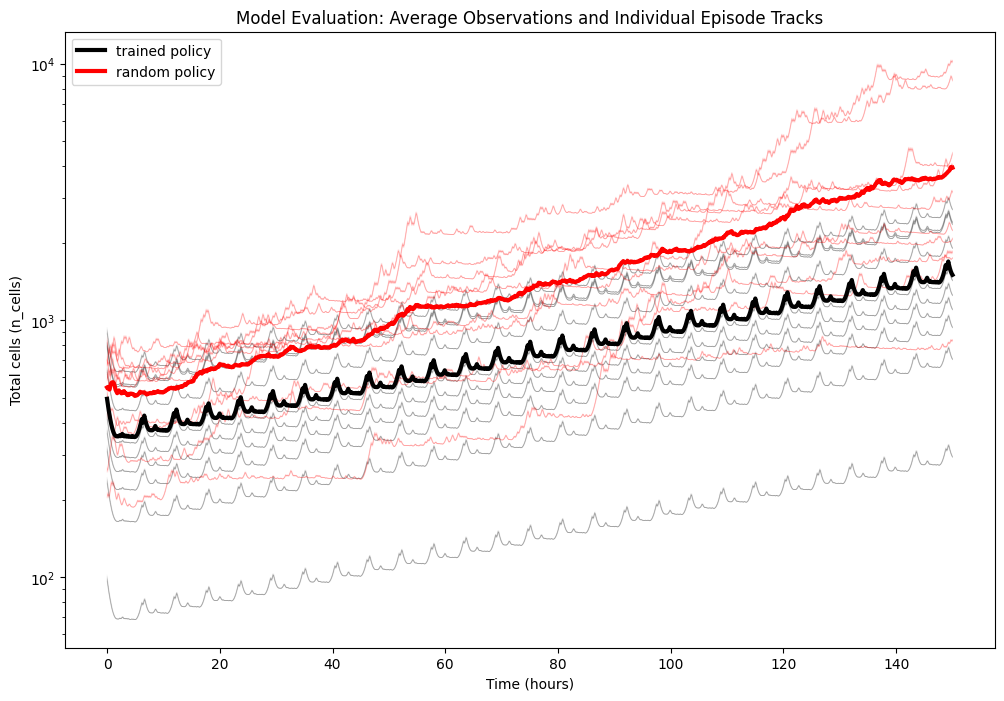

In [37]:
plot_observations(avg_observations, all_observations, unif_obs, all_unif_obs)

In [21]:
# continue training:
model.env_steps = 0
model.learn(total_timesteps=150000)

-------------------------------------
| eval/                 |           |
|    action 0 (%)       | 47.1      |
|    action 1 (%)       | 52.9      |
|    auc                | -5.42e+04 |
|    avg_episode_length | 1e+03     |
|    avg_reward         | 3.2       |
|    fps                | 1.47e+03  |
|    time               | 6.79      |
| rollout/              |           |
|    action 0 (%)       | 12.2      |
|    action 1 (%)       | 87.8      |
|    avg_entropy        | 1.04e-05  |
|    avg_episode_length | 1000      |
|    avg_reward_rate    | -0.287    |
|    beta               | 1         |
|    ep_reward          | -287      |
|    neg_free_energy    | -0.287    |
| time/                 |           |
|    env. steps         | 1000      |
|    fps                | 967       |
|    num. episodes      | 401       |
|    num. updates       | 385000    |
| train/                |           |
|    lr                 | 0.0035    |
|    theta              | 0.138     |
------------

False